In [2]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units

import importlib

import snapshot_obj
import trace_halo
import dataset_compute
import subhalo

In [11]:
importlib.reload(snapshot_obj)
importlib.reload(trace_halo)
importlib.reload(dataset_compute)
importlib.reload(subhalo)

<module 'subhalo' from '/home/kasper/Curvaton_Simulations/APOSTLE_analysis/subhalo.py'>

# Plotting trajectories of halos

## Tracing a satellite

In [5]:
sim_id = "V1_LR_fix"
start = 127; stop = 100
gn=1
snap0 = snapshot_obj.Snapshot(sim_id, start)
central = subhalo.Subhalo(sim_id, start, gn, 0)

First, identify the central halo through snapshots:

In [6]:
tracer = central.trace(stop=stop)
print(tracer)

{127: (1, 0), 126: (1.0, 0.0), 125: (1.0, 0.0), 124: (1.0, 0.0), 123: (1.0, 0.0), 122: (1.0, 0.0), 121: (1.0, 0.0), 120: (1.0, 0.0), 119: (1.0, 0.0), 118: (1.0, 0.0), 117: (1.0, 0.0), 116: (1.0, 0.0), 115: (1.0, 0.0), 114: (1.0, 0.0), 113: (1.0, 0.0), 112: (1.0, 0.0), 111: (1.0, 0.0), 110: (1.0, 0.0), 109: (1.0, 0.0), 108: (1.0, 0.0), 107: (1.0, 0.0), 106: (1.0, 0.0), 105: (1.0, 0.0), 104: (1.0, 0.0), 103: (1.0, 0.0), 102: (1.0, 0.0), 101: (1.0, 0.0), 100: (1.0, 0.0)}


Then, select a satellite that can be traced back through a couple snapshots (for instance, the M31 satellite (1,4)):

In [27]:
sgn=2
satellite = subhalo.Subhalo(sim_id, start, gn, sgn)
sat_tracer = satellite.trace(stop=stop)
print(sat_tracer)

{127: (1, 2), 126: (40.0, 0.0), 125: (51.0, 0.0), 124: (54.0, 0.0), 123: (54.0, 0.0), 122: (51.0, 0.0), 121: (51.0, 0.0), 120: (53.0, 0.0), 119: (56.0, 0.0), 118: (56.0, 0.0), 117: (57.0, 0.0), 116: (55.0, 0.0), 115: (54.0, 0.0), 114: (57.0, 0.0), 113: (57.0, 0.0), 112: (55.0, 0.0), 111: (54.0, 0.0), 110: (55.0, 0.0), 109: (57.0, 0.0), 108: (54.0, 0.0), 107: (58.0, 0.0), 106: (60.0, 0.0), 105: (60.0, 0.0), 104: (57.0, 0.0), 103: (63.0, 0.0), 102: (66.0, 0.0), 101: (68.0, 0.0), 100: (67.0, 0.0)}


Compute the distance from the central halo for each snapshot:

In [28]:
snap_ids = list(sat_tracer.keys())
snap_ids = np.sort(snap_ids)
d = [satellite.distance_to_central(sid) for sid in list(snap_ids)]

In [29]:
print(d)

[array([ 4.29496730e+09, -8.58993459e+09,  0.00000000e+00]), array([4.29496730e+09, 8.58993459e+09, 0.00000000e+00]), array([ 0.00000000e+00, -4.29496730e+09, -1.71798692e+10]), array([ 0.00000000e+00,  4.29496730e+09, -1.71798692e+10]), array([4.29496730e+09, 8.58993459e+09, 1.71798692e+10]), array([0.00000000e+00, 1.28849019e+10, 1.71798692e+10]), array([ 1.71798692e+10, -8.58993459e+09, -1.71798692e+10]), array([ 4.2949673e+09, -4.2949673e+09,  0.0000000e+00]), array([1.28849019e+10, 1.71798692e+10, 0.00000000e+00]), array([-4.2949673e+09, -4.2949673e+09,  0.0000000e+00]), array([4.29496730e+09, 8.58993459e+09, 3.43597384e+10]), array([ 1.71798692e+10, -1.28849019e+10, -3.43597384e+10]), array([ 0.00000000e+00, -8.58993459e+09,  0.00000000e+00]), array([ 1.28849019e+10, -1.28849019e+10,  0.00000000e+00]), array([8.58993459e+09, 0.00000000e+00, 0.00000000e+00]), array([0.00000000e+00, 1.71798692e+10, 3.43597384e+10]), array([-1.28849019e+10,  8.58993459e+09, -3.43597384e+10]), array(

In [30]:
d = np.array(d).reshape((len(d),3)) * units.cm.to(units.kpc)

Plot in the xy- and xz-plane:

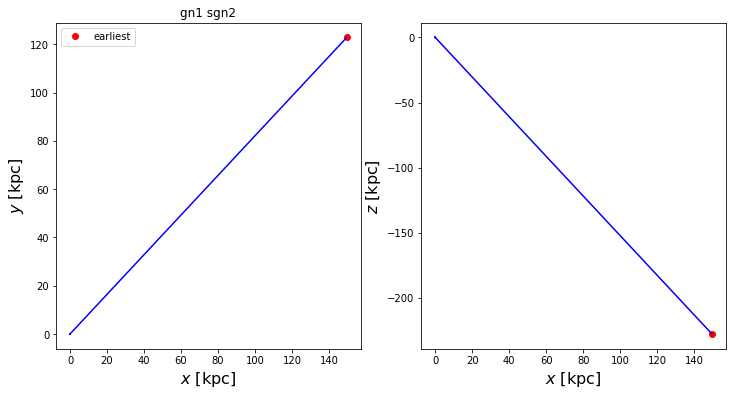

In [31]:
fig,ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].plot(d[-1,0], d[-1,1], 'ro', label='earliest')
ax[0].plot(d[:,0], d[:,1], 'b')
ax[0].set_xlabel('$x$ [kpc]', fontsize=16)
ax[0].set_ylabel('$y$ [kpc]', fontsize=16)

ax[1].plot(d[-1,0], d[-1,2], 'ro')
ax[1].plot(d[:,0], d[:,2], 'b')
ax[1].set_xlabel('$x$ [kpc]', fontsize=16)
ax[1].set_ylabel('$z$ [kpc]', fontsize=16)

ax[0].legend()

# Save figure:

filename = 'satellite_trajectory_gn{}sgn{}.png'.format(gn,sgn)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")

# If the directory does not exist, create it
#if not os.path.exists(path):
#    os.makedirs(path)
#plt.savefig(os.path.join(path,filename), dpi=200)

# Plot evolution of mass components

In [19]:
z = np.zeros(snap_ids.size)
for i,sid in enumerate(snap_ids):
    z[i] = snapshot_obj.Snapshot(sim_id, sid).get_attribute('Redshift', 'Header')

In [20]:
masses = np.zeros((snap_ids.size, 6))
for i,sid in enumerate(snap_ids):
    masses[i] = satellite.get_halo_data("MassType", sid) * units.g.to(units.Msun)

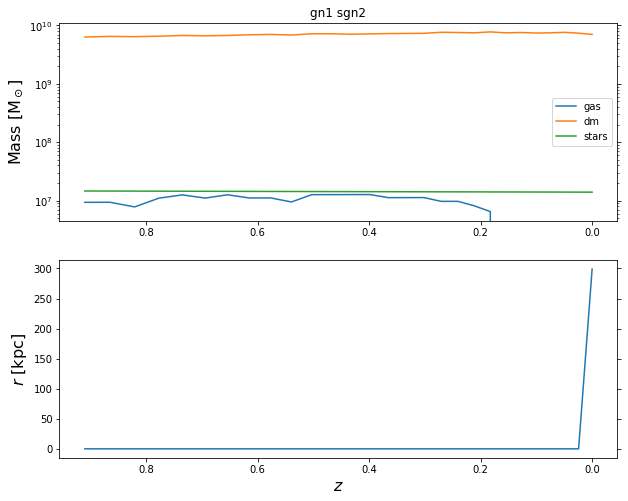

In [21]:
fig,ax = plt.subplots(nrows=2, figsize=(10,8))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].set_yscale('log')
ax[0].set_ylabel('Mass $[\mathrm{M_\odot}]$', fontsize=16)

ax[1].set_xlabel('$z$', fontsize=16)
ax[1].set_ylabel('$r$ [kpc]', fontsize=16)

ax[0].yaxis.set_ticks_position('both')
ax[1].yaxis.set_ticks_position('both')

ax[0].invert_xaxis()
ax[1].invert_xaxis()

for pt,l in zip([0,1,4],['gas', 'dm', 'stars']):
    ax[0].plot(z, masses[:,pt], label=l)
    
ax[0].legend()

ax[1].plot(z, np.linalg.norm(d, axis=1))

# Save figure:

filename = 'satellite_mass_evol_gn{}sgn{}.png'.format(gn,sgn)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)